In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from sklearn.decomposition import NMF
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

In [2]:
# loading all ITPC spectrum from all shafts in both left and right aac during syllable presentation
#[12 aac_left_pa, 12 aac_left_ba, 12 aac_right_pa, 12 aac_right_ba] 
all_shafts = np.load("/home/jeremy/Desktop/asymmetric-sampling-master/data/fig7/all_shafts_ba_pa.npy")

#individual boundaries for number of shafts
limits = np.load("/home/jeremy/Desktop/asymmetric-sampling-master/data/fig7/all_shafts_ba_pa_individual_limits.npy")

In [3]:
# using nmf to find components 

X = all_shafts.T.copy()
model = NMF(n_components=4, init='nndsvd', solver= 'cd',random_state=42,max_iter=1000, alpha=0.01)
W = model.fit_transform(X)
H = model.components_
scores = W.copy()

In [4]:
# getting weights from each hemisphere
left_score = scores[0:limits[24],:]
right_score = scores[limits[24]::,:]

In [5]:
# group together delta/beta components and theta/gamma components 
idl1 = 3; idl2 = 3; idr1 = 1; idr2 = 1 # components #
nleft = 24 # ba&pa


xl = []; yl = []
xr = []; yr = []
x = []
for num,j in enumerate(limits):
    if num == 0: # patients left first
        xl.append(np.mean(np.concatenate(scores[0:j,[idl1,idl2]],0) ,0))
        yl.append(np.mean(np.concatenate(scores[0:j, [idr1,idr2]],0) ,0))
    elif num < nleft:
        xl.append(np.mean(np.concatenate(scores[limits[num - 1] + 1:j , [idl1,idl2]],0) ,0))
        yl.append(np.mean(np.concatenate(scores[limits[num - 1] + 1:j, [idr1, idr2]],0),0))
    else:
        xr.append(np.mean(np.concatenate(scores[limits[num - 1] + 1:j, [idl1, idl2]],0),0))
        yr.append(np.mean(np.concatenate(scores[limits[num - 1] + 1:j, [idr1, idr2]],0) ,0))
xl = np.mean(np.reshape(xl,(2,12)),0)
yl = np.mean(np.reshape(yl,(2,12)),0)
xr = np.mean(np.reshape(xr,(2,12)),0)
yr = np.mean(np.reshape(yr,(2,12)),0)

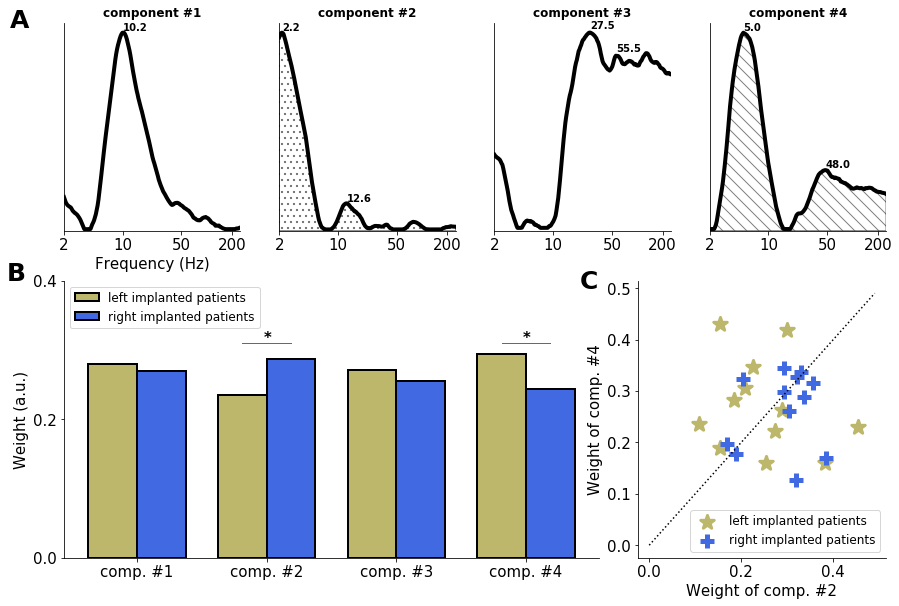

In [6]:
freqs = np.logspace(*np.log10([2, 250]), num = 200)

fig7, axs = plt.subplots(2,4,figsize = (12,8))

gs1 = gridspec.GridSpec(2, 12, height_ratios=[0.3,0.4])

for i, (num, ax) in enumerate(zip(range(4),axs.ravel())):
        if num < 4:
            ax = plt.subplot(gs1[num * 3 : num * 3 + 3])  
            ax.plot(freqs,H[num,:], linewidth = 4,color = 'k')
            ax.set_xscale('log')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
            ax.xaxis.set_minor_formatter(ticker.NullFormatter())
            ax.xaxis.set_minor_locator(ticker.NullLocator())
            tick_vals = np.array([2,10,50,200])
            tick_vals = tick_vals.astype(int)
            ax.set_xticks(tick_vals)
            ax.yaxis.set_minor_formatter(ticker.NullFormatter())
            ax.yaxis.set_minor_locator(ticker.NullLocator())
            if num == 0:    
                ax.text(0.45,1.35, "A", fontsize = 25, weight = 'bold')
                ax.set_xlabel('Frequency (Hz)', fontsize = 15)
            ax.set_title("component #"+str(num+ 1), weight = 'bold')
            if num == 3:
                ax.fill_between(freqs,H[num,:],-0.01, hatch = '\\\\' , facecolor = 'none',alpha = 0.5)
            if num == 1:
                ax.fill_between(freqs,H[num,:],-0.01, hatch = '..' , facecolor = 'none',alpha = 0.5)
            ax.set_xlim(2,250)
            ax.set_ylim(-0.01)
            ax.set_yticks([])
            ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
            spectra = H[num,:].copy()
            b = find_peaks(spectra,prominence = 0.035, distance = 20)
            freq_ind = b[0]
            for j in freq_ind[0:2]:
                ax.text(freqs[j], np.take(spectra,j) + 0.015, str(np.round(freqs[j],1)), weight = 'bold')
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 0.5);  


ax = plt.subplot(gs1[12:20])                
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.bar([0,.8,1.6,2.4], np.mean(left_score,0), width = 0.3, label = 'left implanted patients', color = ('darkkhaki','darkkhaki' ), align = 'center', edgecolor = 'k', linewidth = 2)
ax.bar([0.3,1.1,1.9,2.7], np.mean(right_score,0), width = 0.3, label = 'right implanted patients', color = ('royalblue', 'royalblue'), align = 'center', edgecolor = 'k', linewidth = 2)
ax.set_xticks([.15,.95,1.75,2.55])
ax.set_yticks([0,.2,.4])
ax.set_xticklabels(["comp. #1","comp. #2","comp. #3","comp. #4"], fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Weight (a.u.)',fontsize = 15)
ax.legend(fontsize = 12, loc = 2)
ax.set_ylim(0,.4)
ax.text(-0.65,.4, "B", fontsize = 25, weight = 'bold')
ax.plot([0.8, 1.1], [.31, .31], 'dimgrey', lw = 1)
ax.text(0.93, .31, '*', color = 'k', weight = 'bold', fontsize = 15)
ax.plot([2.4, 2.7], [.31, .31], 'dimgrey', lw = 1)
ax.text(2.53, .31, '*', color = 'k', weight = 'bold', fontsize = 15)

ax = plt.subplot(gs1[20::])  
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.scatter(yl,xl, color = 'darkkhaki',label = 'left implanted patients', linewidth='3',marker = '*', s = 200)
ax.scatter(yr,xr, color = 'royalblue',label = 'right implanted patients', linewidth='5', marker = '+', s = 200)
ax.plot(np.arange(0,0.5,0.01),np.arange(0,0.5,0.01), color = 'k', linestyle = ':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Weight of comp. #2', fontsize = 15)
ax.set_ylabel('Weight of comp. #4' , fontsize = 15)
ax.text(-0.15,0.5, "C", fontsize = 25, weight = 'bold')
ax.legend(fontsize = 12, loc = 4);